In [1]:
import nltk

In [69]:
import warnings
warnings.filterwarnings('ignore')

*  rstrip extracts by removing the whitespace from the end.  

In [4]:
messages=[line.rstrip() for line in open('SMSSpamCollection')]

In [5]:
len(messages)

5574

In [6]:
'''for msno,msg in enumerate(messages):
    print(msno,msg)
    print('\n')'''

"for msno,msg in enumerate(messages):\n    print(msno,msg)\n    print('\n')"

In [7]:
import pandas as pd

* messages is a tab seperated file

In [8]:
messages=pd.read_csv('SMSSpamCollection',sep='\t',names=['label','message'])

In [9]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

* make a new parameter: length 

In [11]:
messages['length']=messages['message'].apply(len)

In [12]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [13]:
import matplotlib.pyplot as plt
import seaborn as sb

In [14]:
%matplotlib inline

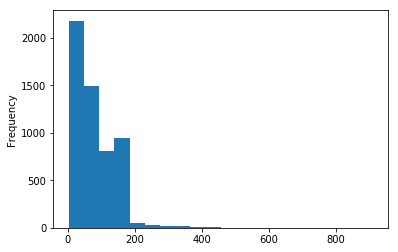

In [15]:
messages['length'].plot(bins=20,kind='hist')

In [16]:
messages['length'].mean()

80.48994974874371

In [17]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A7EB22C4E0>,
      dtype=object)

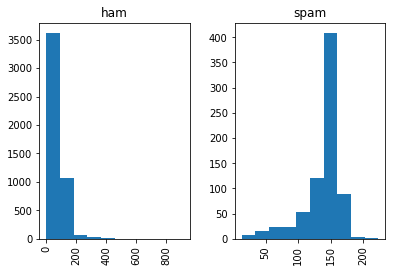

In [18]:
messages.hist(column='length',by='label')

* spam messagaes are longer (on avg)

In [19]:
messages.groupby('label').mean()

,length
label,
ham,71.482487
spam,138.670683


# removing punctuation and stop words - analyser

In [20]:
from nltk.corpus import stopwords

In [21]:
from string import punctuation

In [22]:
# custom analyser
def text_processing(s):
    nopunc=[char for char in s if (char not in punctuation)]
    nopunc=''.join(nopunc)
    return[word for word in nopunc.split() if word not in stopwords.words('english')]

In [23]:
'''for ele in punctuation:
    print(ele)
    print('\n')'''
# run to see punctuations 

"for ele in punctuation:\n    print(ele)\n    print('\n')"

In [24]:
messages['message'].head(5)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [25]:
messages['message'].head(5).apply(text_processing)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, I, dont, think, goes, usf, lives, around...
Name: message, dtype: object

In [26]:
# the stopwords list
#((stopwords).words('english'))[:20]

In [27]:
import sklearn

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
bow_transformer=CountVectorizer(analyzer=text_processing).fit(messages['message'])

In [30]:
len(bow_transformer.vocabulary_)

11617

In [31]:
bow_transformer.get_feature_names()[6111]

'decision'

In [32]:
messages_bow=bow_transformer.transform(messages['message'])

In [33]:
(messages_bow).shape

(5572, 11617)

* Computing sparsity of matrix

In [34]:
((messages_bow.nnz)/(5572*11617))*100

0.08655038742205227

# TF-IDF Vectorization

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

In [36]:
tfidf_transformer=TfidfTransformer().fit(messages_bow)

In [37]:
# transform bow to tfidf corpus
messages_tfidf=tfidf_transformer.transform(messages_bow)

In [38]:
type(messages_tfidf)

scipy.sparse.csr.csr_matrix

In [39]:
messages_tfidf.shape

(5572, 11617)

In [40]:
tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]

3.2800524267409408

# Using NB algo.

In [41]:
from sklearn.naive_bayes import MultinomialNB

In [42]:
from sklearn.pipeline import Pipeline

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
train_data,test_data,train_label,test_label=train_test_split(messages['message'],messages['label'],test_size=0.2)

In [45]:
type(train_label)

pandas.core.series.Series

* Pipeline created into which data can be directly enetred for the sequence of operations.

In [46]:
pipeline=Pipeline([('bow',CountVectorizer(analyzer=text_processing)),('tfidf',TfidfTransformer()),('ml',MultinomialNB())])

In [47]:
pipeline.fit(train_data,train_label)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_processing at 0x000001A7EB3728C8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...linear_tf=False, use_idf=True)), ('ml', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [48]:
from sklearn.metrics import classification_report 

In [49]:
from sklearn.metrics import balanced_accuracy_score

In [50]:
predictions=pipeline.predict(test_data)

In [51]:
print(classification_report(predictions,test_label))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.97      1011
        spam       0.68      1.00      0.81       104

   micro avg       0.96      0.96      0.96      1115
   macro avg       0.84      0.98      0.89      1115
weighted avg       0.97      0.96      0.96      1115



In [52]:
print(balanced_accuracy_score(predictions,test_label))

0.9752720079129575


In [53]:
from sklearn.metrics import confusion_matrix

In [54]:
confusion_matrix(predictions,test_label)

array([[961,  50],
       [  0, 104]], dtype=int64)

# using SVM

In [55]:
from sklearn.svm import SVC

In [56]:
pipeline1=Pipeline([('bow',CountVectorizer(analyzer=text_processing)),('tfidf',TfidfTransformer()),('SVM',SVC())])

In [57]:
pipeline1.fit(train_data,train_label)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_processing at 0x000001A7EB3728C8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [58]:
predictions1=pipeline1.predict(test_data)

In [59]:
confusion_matrix(predictions1,test_label)

array([[961, 154],
       [  0,   0]], dtype=int64)

In [71]:
print(classification_report(predictions1,test_label))

              precision    recall  f1-score   support

         ham       1.00      0.86      0.93      1115
        spam       0.00      0.00      0.00         0

   micro avg       0.86      0.86      0.86      1115
   macro avg       0.50      0.43      0.46      1115
weighted avg       1.00      0.86      0.93      1115



* clearly something is not right with the SVC parameters.

# using logistic regression classifier

In [72]:
from sklearn.linear_model import LogisticRegression

In [73]:
lr=LogisticRegression(solver='liblinear',penalty='l1')

In [74]:
pipeline2=Pipeline([('bow',CountVectorizer(analyzer=text_processing)),('tfidf',TfidfTransformer()),('lr1',LogisticRegression(solver='liblinear',penalty='l1'))])

In [75]:
pipeline2.fit(train_data,train_label)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_processing at 0x000001A7EB3728C8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproce...ty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [76]:
predictions2=pipeline2.predict(test_data)

In [77]:
print(classification_report(predictions2,test_label))

              precision    recall  f1-score   support

         ham       0.99      0.95      0.97      1004
        spam       0.68      0.95      0.79       111

   micro avg       0.95      0.95      0.95      1115
   macro avg       0.84      0.95      0.88      1115
weighted avg       0.96      0.95      0.95      1115



In [78]:
print(confusion_matrix(predictions2,test_label))

[[955  49]
 [  6 105]]


In [79]:
balanced_accuracy_score(predictions2,test_label)

0.9485705825347259

* clearly, multinomial NB performs best out of the 3 for SMS spam filtering.